##Library

In [ ]:
!pip3 install torch torchvision torchaudio torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=d138d136a436022f04e35d5b44d678459d37330b4e698db97126aa22531cd6e4
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
import os
import pickle
import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
from sklearn.metrics import confusion_matrix
import seaborn as sns
import sklearn as skl
# import pandas as pd
#import dill

import copy
from sklearn.model_selection import train_test_split
import json
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# from google.colab import files
# from google.colab import drive
# drive.mount('/content/drive')

## Fashion MNIST dataset

In [ ]:

transform = transforms.Compose([transforms.ToTensor()])

# Armo un diccionario para los labels
labels_names = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# Descargo el conjunto de datos Fashion MNIST
train_set = datasets.FashionMNIST('MNIST_data/', download=True, train=True, transform=transform)
valid_set_orig = datasets.FashionMNIST('MNIST_data/', download=True, train=False, transform=transform)

# Divido el conjunto de validación en conjuntos de prueba y validación
train_indices, test_indices = train_test_split(range(len(train_set)), test_size=0.16666, random_state=42)

# Creo conjuntos de validación y prueba
train_set_orig = Subset(train_set, train_indices)
test_set_orig = Subset(train_set, test_indices)

100%|██████████| 26421880/26421880 [00:01<00:00, 16595847.97it/s]


Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 300105.90it/s]


Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5436357.68it/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20160856.20it/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



In [ ]:
#transformo los data sets para el caso de los autoencoders donde out=in
class CustomDataset(Dataset):
    def __init__(self,dataset):
        self.dataset=dataset
    # Redefinimos el método .__len__()
    def __len__(self):
        return len(self.dataset)
    # Redefinimos el método .__getitem__()
    def __getitem__(self,i):
        image,label=self.dataset[i]
        input  = image
        output = image # Reescribimos el label original por la misma imagen
        return input,output
# Convertimos FashionMNIST Dataset a CustomDataset
train_set = CustomDataset(train_set_orig)
valid_set = CustomDataset(valid_set_orig)
test_set=CustomDataset(test_set_orig)

# Convolutional autoencoder

## Implementing the model

In [ ]:
# defino el AC
class Autoencoder_conv(nn.Module):
    def __init__(self,n=64,p=0.2):
      super().__init__()
      self.n=n
      self.p=p
      self.encoder=nn.Sequential(
          #convolutional 1°
            nn.Conv2d(1,16,kernel_size=3), # (1,28,28)--->(16,26,26)
            nn.ReLU() ,# "capa" relu
            nn.Dropout(self.p), # "capa" dropout
            nn.MaxPool2d(2,2), #kernel_size=(2,2),   (26,26)---->(13,13)
          #convolutional 2°
            nn.Conv2d(16,32,kernel_size=3), # (16,13,13)--->(32,11,11)
            nn.ReLU() ,# "capa" relu
            nn.Dropout(self.p), # "capa" dropout
            nn.MaxPool2d(2,2), #kernel_size=(2,2),   (32,11,11)---->(32,5,5)

          #linear
            nn.Flatten(),
            nn.Linear(32*5*5,self.n), # fc2 = "capa" fully connected 2
            nn.ReLU() ,
            nn.Dropout(self.p)
        )
      #decoder
      self.decoder=nn.Sequential(
          #linear
            nn.Linear(self.n,32*5*5),
            nn.ReLU() ,
            nn.Dropout(self.p),
            nn.Unflatten(1,(32,5,5)), # 32*5*5--->(32,5,5)
          #transpose convolutional 1°
            nn.ConvTranspose2d(32,16,kernel_size=4,stride=2,output_padding=1),
            nn.ReLU(),
            nn.Dropout(self.p),
          #transpose conv 2°
            nn.ConvTranspose2d(16,1,kernel_size=3,stride=2,output_padding=1),
            nn.Sigmoid(),
            # nn.Dropout(self.p)
       )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# estas funciones ayudan a la interpretacion de las entradas
def batch(image):
  return image.unsqueeze(0)#(28,28)--->(1,28,28) cuando usemos el modelo hay que meterle algo de este formato!

def unbatch(image):
  return image.squeeze().detach().cpu().numpy() #(1,28,28)--->(28,28) cuando grafiquemos hay que mterle algo de este formato

In [ ]:
#implemento loop de entrenamiento
def train_loop_AE(dataloader,model,loss_fn,optimizer):
    # Activamos la maquinaria de entrenamiento del modelo
    model.train()
    # Definimos ciertas constantes
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_loss = 0
    #copio al dispositiov de trabajo
    model=model.to(device)
    # Iteramos sobre lotes (batchs)
    for batch, (X, y) in enumerate(dataloader):
        # Copiamos las entradas y las salidas al dispositivo de trabajo
        X = X.to(device)
        y = y.to(device)
        # Calculamos la predicción del modelo y la correspondiente pérdida (error)
        pred = model(X)
        loss = loss_fn(pred,y)
        # Backpropagamos usando el optimizador proveido.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Imprimimos el progreso...
        loss_batch = loss.item()
        sum_loss += loss_batch

        if batch % 100 == 0:
            current = batch*len(X)
            print(f"@train_loop batch={batch:>5d} loss={loss:>7f}  muestras-procesadas=[{current:>5d}/{size:>5d}]")
    avg_loss = sum_loss/num_batches

    return avg_loss

#implemento el loop de validacion
def valid_loop_AE(dataloader,model,loss_fn):
    # Desactivamos la maquinaria de entrenamiento del modelo
    model.eval()
    # Definimos ciertas constantes
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_loss,sum_correct=0,0
    model=model.to(device)
    # Para testear, desactivamos el cálculo de gradientes.
    with torch.no_grad():
        # Iteramos sobre lotes (batches)
        for X,y in dataloader:
            # Copiamos las entradas y las salidas al dispositivo de trabajo
            X ,y= X.to(device),y.to(device)
            # Calculamos las predicciones del modelo...
            pred = model(X)
            # y las correspondientes pérdidas (errores), los cuales vamos acumulando en un valor total.
            loss_batch= loss_fn(pred,y).item()
            sum_loss += loss_batch

    # Calculamos la pérdida total y la fracción de clasificaciones correctas, y las imprimimos.
    avg_loss = sum_loss/num_batches

    print(f"Validacion:% avg_loss={avg_loss:>8f}")
    return avg_loss

## Variate some hyperparams($p,lr,n$)
Where $p$ is the Dropout probability, $n$ is the number of elements present in the encoder output (on the lineal layer), and $lr$ is the learning rate.

In [ ]:
num_epochs=30

### variacion de $n$

Epoch 1
-------------------------------
@train_loop batch=    0 loss=0.176717  muestras-procesadas=[    0/50000]
@train_loop batch=  100 loss=0.081958  muestras-procesadas=[10000/50000]
@train_loop batch=  200 loss=0.067644  muestras-procesadas=[20000/50000]
@train_loop batch=  300 loss=0.057867  muestras-procesadas=[30000/50000]
@train_loop batch=  400 loss=0.052926  muestras-procesadas=[40000/50000]
Validacion:% avg_loss=0.048996
Validacion:% avg_loss=0.049015
Epoch 2
-------------------------------
@train_loop batch=    0 loss=0.052489  muestras-procesadas=[    0/50000]
@train_loop batch=  100 loss=0.044868  muestras-procesadas=[10000/50000]
@train_loop batch=  200 loss=0.044438  muestras-procesadas=[20000/50000]
@train_loop batch=  300 loss=0.044703  muestras-procesadas=[30000/50000]
@train_loop batch=  400 loss=0.046225  muestras-procesadas=[40000/50000]
Validacion:% avg_loss=0.043276
Validacion:% avg_loss=0.043345
Epoch 3
-------------------------------
@train_loop batch=    0 lo

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 28, 28])) that is different to the input size (torch.Size([1, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


error testeo 0.039394022484501565 n= 64
Epoch 1
-------------------------------
@train_loop batch=    0 loss=0.161778  muestras-procesadas=[    0/50000]
@train_loop batch=  100 loss=0.066473  muestras-procesadas=[10000/50000]
@train_loop batch=  200 loss=0.056090  muestras-procesadas=[20000/50000]
@train_loop batch=  300 loss=0.050922  muestras-procesadas=[30000/50000]
@train_loop batch=  400 loss=0.046420  muestras-procesadas=[40000/50000]
Validacion:% avg_loss=0.044581
Validacion:% avg_loss=0.044631
Epoch 2
-------------------------------
@train_loop batch=    0 loss=0.045674  muestras-procesadas=[    0/50000]
@train_loop batch=  100 loss=0.044273  muestras-procesadas=[10000/50000]
@train_loop batch=  200 loss=0.041631  muestras-procesadas=[20000/50000]
@train_loop batch=  300 loss=0.042104  muestras-procesadas=[30000/50000]
@train_loop batch=  400 loss=0.036795  muestras-procesadas=[40000/50000]
Validacion:% avg_loss=0.040800
Validacion:% avg_loss=0.040910
Epoch 3
------------------

Text(0, 0.5, 'Error(ECM)')

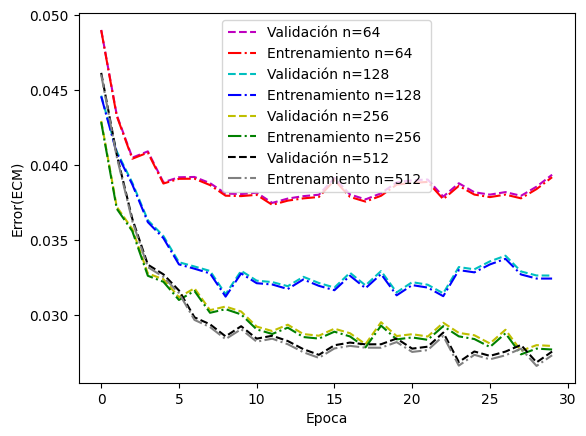

In [ ]:
loss_fn = nn.MSELoss()
batch_size = 100
train_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size,shuffle=True)
lista_n=[64,128,256,512]
p=0.2
colores=['m','c','y','k']
colores_2=['r','b','g','grey']
listas_train=[]
listas_valid=[]
for i in range(len(lista_n)):
  n=lista_n[i]
  model=Autoencoder_conv(n=n,p=p)
  learning_rate = 1e-3 # necesario para definir
  optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)
  num_epochs=num_epochs
  list_train_avg_loss_incorrecta = []
  list_train_avg_loss = []
  list_valid_avg_loss = []

  for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        train_avg_loss_incorrecta = train_loop_AE(train_loader,model,loss_fn,optimizer)
        train_avg_loss = valid_loop_AE(train_loader,model,loss_fn)
        valid_avg_loss = valid_loop_AE(valid_loader,model,loss_fn)
        list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)
        list_train_avg_loss.append(train_avg_loss)
        list_valid_avg_loss.append(valid_avg_loss)

  print("Done!")
  listas_train.append(list_train_avg_loss)
  listas_valid.append(list_valid_avg_loss)
  suma_error_testeo=0
  # ahora calculo los errores con el conjunto de testeo:
  for kg,elemento in enumerate(test_set):
    imagen_testeo,imagen_flatten_testeo=test_set[kg]
    predic=model((batch(imagen_testeo)))
    loss_batch= loss_fn(predic,imagen_flatten_testeo).item()
    suma_error_testeo += loss_batch
  promedio_error_testeo=suma_error_testeo/kg
  print('error testeo',promedio_error_testeo,'n=',n)
for j in range(len(lista_n)):
  plt.plot(range(num_epochs),listas_valid[j],color=colores[j],label=f'Validación n={lista_n[j]} ',linestyle='--')
  plt.plot(range(num_epochs),listas_train[j],color=colores_2[j],label=f'Entrenamiento n={lista_n[j]} ',linestyle='-.')
plt.legend()
plt.xlabel('Epoca')
plt.ylabel('Error(ECM)')



###varios $p$

Epoch 1
-------------------------------
@train_loop batch=    0 loss=0.191087  muestras-procesadas=[    0/50000]
@train_loop batch=  100 loss=0.083465  muestras-procesadas=[10000/50000]
@train_loop batch=  200 loss=0.063552  muestras-procesadas=[20000/50000]
@train_loop batch=  300 loss=0.053702  muestras-procesadas=[30000/50000]
@train_loop batch=  400 loss=0.046856  muestras-procesadas=[40000/50000]
Validacion:% avg_loss=0.043267
Validacion:% avg_loss=0.043375
Epoch 2
-------------------------------
@train_loop batch=    0 loss=0.044912  muestras-procesadas=[    0/50000]
@train_loop batch=  100 loss=0.044431  muestras-procesadas=[10000/50000]
@train_loop batch=  200 loss=0.039350  muestras-procesadas=[20000/50000]
@train_loop batch=  300 loss=0.040300  muestras-procesadas=[30000/50000]
@train_loop batch=  400 loss=0.038562  muestras-procesadas=[40000/50000]
Validacion:% avg_loss=0.036173
Validacion:% avg_loss=0.036306
Epoch 3
-------------------------------
@train_loop batch=    0 lo

Text(0, 0.5, 'Error(ECM)')

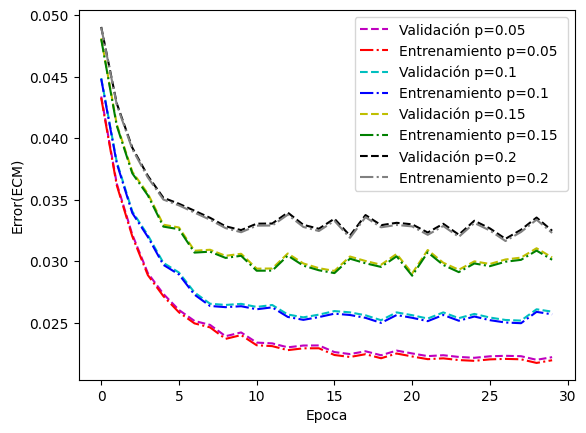

In [ ]:
batch_size = 100
train_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size,shuffle=True)
lista_p=[0.05,0.1,0.15,0.2]

colores=['m','c','y','k']
colores_2=['r','b','g','grey']
listas_train=[]
listas_valid=[]
for i in range(len(lista_n)):
  n=128
  p=lista_p[i]
  model=Autoencoder_conv(n=n,p=p)
  learning_rate = 1e-3 # necesario para definir
  optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)
  num_epochs=num_epochs
  list_train_avg_loss_incorrecta = []
  list_train_avg_loss = []
  list_valid_avg_loss = []

  for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        train_avg_loss_incorrecta = train_loop_AE(train_loader,model,loss_fn,optimizer)
        train_avg_loss = valid_loop_AE(train_loader,model,loss_fn)
        valid_avg_loss = valid_loop_AE(valid_loader,model,loss_fn)
        list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)
        list_train_avg_loss.append(train_avg_loss)
        list_valid_avg_loss.append(valid_avg_loss)

  print("Done!")
  listas_train.append(list_train_avg_loss)
  listas_valid.append(list_valid_avg_loss)
  suma_error_testeo=0
  # ahora calculo los errores con el conjunto de testeo:
  for kg,elemento in enumerate(test_set):
    imagen_testeo,imagen_flatten_testeo=test_set[kg]
    predic=model((batch(imagen_testeo)))
    loss_batch= loss_fn(predic,imagen_flatten_testeo).item()
    suma_error_testeo += loss_batch
  promedio_error_testeo=suma_error_testeo/kg
  print('error_testeo:',promedio_error_testeo,'p=',p)
for j in range(len(lista_p)):
  plt.plot(range(num_epochs),listas_valid[j],color=colores[j],label=f'Validación p={lista_p[j]} ',linestyle='--')
  plt.plot(range(num_epochs),listas_train[j],color=colores_2[j],label=f'Entrenamiento p={lista_p[j]} ',linestyle='-.')
plt.legend()
plt.xlabel('Epoca')
plt.ylabel('Error(ECM)')

###Vario $lr$

Epoch 1
-------------------------------
@train_loop batch=    0 loss=0.194380  muestras-procesadas=[    0/50000]
@train_loop batch=  100 loss=0.046837  muestras-procesadas=[10000/50000]
@train_loop batch=  200 loss=0.039430  muestras-procesadas=[20000/50000]
@train_loop batch=  300 loss=0.035977  muestras-procesadas=[30000/50000]
@train_loop batch=  400 loss=0.032912  muestras-procesadas=[40000/50000]
Validacion:% avg_loss=0.029031
Validacion:% avg_loss=0.029178
Epoch 2
-------------------------------
@train_loop batch=    0 loss=0.032133  muestras-procesadas=[    0/50000]
@train_loop batch=  100 loss=0.036046  muestras-procesadas=[10000/50000]
@train_loop batch=  200 loss=0.030733  muestras-procesadas=[20000/50000]
@train_loop batch=  300 loss=0.028780  muestras-procesadas=[30000/50000]
@train_loop batch=  400 loss=0.030495  muestras-procesadas=[40000/50000]
Validacion:% avg_loss=0.026305
Validacion:% avg_loss=0.026487
Epoch 3
-------------------------------
@train_loop batch=    0 lo

Text(0, 0.5, 'Error(ECM)')

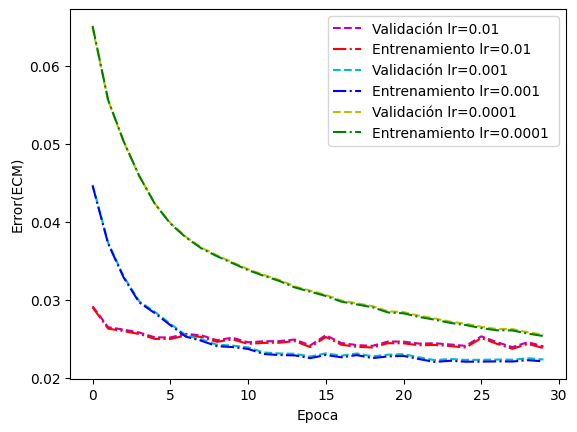

In [ ]:
batch_size = 100
train_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size,shuffle=True)
lista_lr=[0.01,0.001,0.0001]

colores=['m','c','y','k']
colores_2=['r','b','g','grey']
listas_train=[]
listas_valid=[]
for i in range(len(lista_lr)):
  n=128
  p=0.05
  model=Autoencoder_conv(n=n,p=p)
  learning_rate = lista_lr[i] # necesario para definir
  optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)
  num_epochs=num_epochs
  list_train_avg_loss_incorrecta = []
  list_train_avg_loss = []
  list_valid_avg_loss = []

  for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        train_avg_loss_incorrecta = train_loop_AE(train_loader,model,loss_fn,optimizer)
        train_avg_loss = valid_loop_AE(train_loader,model,loss_fn)
        valid_avg_loss = valid_loop_AE(valid_loader,model,loss_fn)
        list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)
        list_train_avg_loss.append(train_avg_loss)
        list_valid_avg_loss.append(valid_avg_loss)

  print("Done!")
  listas_train.append(list_train_avg_loss)
  listas_valid.append(list_valid_avg_loss)
  suma_error_testeo=0
  # ahora calculo los errores con el conjunto de testeo:
  for kg,elemento in enumerate(test_set):
    imagen_testeo,imagen_flatten_testeo=test_set[kg]
    predic=model((batch(imagen_testeo)))
    loss_batch= loss_fn(predic,imagen_flatten_testeo).item()
    suma_error_testeo += loss_batch
  promedio_error_testeo=suma_error_testeo/kg
  print('promedio error testeo',promedio_error_testeo,'lr=',learning_rate)
for j in range(len(lista_lr)):
  plt.plot(range(num_epochs),listas_valid[j],color=colores[j],label=f'Validación lr={lista_lr[j]} ',linestyle='--')
  plt.plot(range(num_epochs),listas_train[j],color=colores_2[j],label=f'Entrenamiento lr={lista_lr[j]} ',linestyle='-.')
plt.legend()
plt.xlabel('Epoca')
plt.ylabel('Error(ECM)')

## Train the model with the best hyperparams
And recreate the input image at the output

In [ ]:
num_epochs=30

Epoch 1 de 30
-------------------------------
@train_loop batch=    0 loss=0.159571  muestras-procesadas=[    0/50000]
@train_loop batch=  100 loss=0.063959  muestras-procesadas=[10000/50000]
@train_loop batch=  200 loss=0.053517  muestras-procesadas=[20000/50000]
@train_loop batch=  300 loss=0.046739  muestras-procesadas=[30000/50000]
@train_loop batch=  400 loss=0.043943  muestras-procesadas=[40000/50000]
Validacion:% avg_loss=0.038650
Validacion:% avg_loss=0.038743
Epoch 2 de 30
-------------------------------
@train_loop batch=    0 loss=0.039629  muestras-procesadas=[    0/50000]
@train_loop batch=  100 loss=0.041712  muestras-procesadas=[10000/50000]
@train_loop batch=  200 loss=0.035656  muestras-procesadas=[20000/50000]
@train_loop batch=  300 loss=0.036085  muestras-procesadas=[30000/50000]
@train_loop batch=  400 loss=0.035542  muestras-procesadas=[40000/50000]
Validacion:% avg_loss=0.033006
Validacion:% avg_loss=0.033134
Epoch 3 de 30
-------------------------------
@train_l

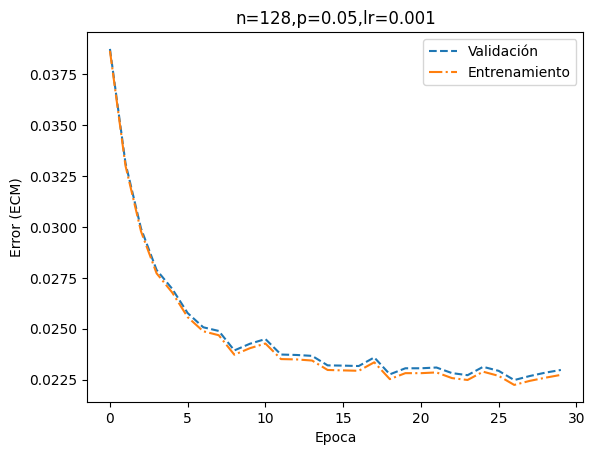

In [ ]:
loss_fn = nn.MSELoss()
batch_size = 100
train_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size,shuffle=True)
n=128
p=0.05
model=Autoencoder_conv(n=n,p=p)
learning_rate = 1e-3 # necesario para definir
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Pasamos el modelo al dispositivo
model = model.to(device)



list_train_avg_loss_incorrecta = []
list_train_avg_loss = []
list_valid_avg_loss = []

for epoch in range(num_epochs):
      print(f"Epoch {epoch+1} de {num_epochs}\n-------------------------------")
      train_avg_loss_incorrecta = train_loop_AE(train_loader,model,loss_fn,optimizer)
      train_avg_loss = valid_loop_AE(train_loader,model,loss_fn)
      valid_avg_loss = valid_loop_AE(valid_loader,model,loss_fn)
      list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)
      list_train_avg_loss.append(train_avg_loss)
      list_valid_avg_loss.append(valid_avg_loss)

print("Done!")

plt.xlabel('Epoca')
plt.ylabel('Error (ECM)')
plt.plot(range(0,len(list_valid_avg_loss)),list_valid_avg_loss,label='Validación',linestyle='--')
plt.plot(range(0,len(list_train_avg_loss)),list_train_avg_loss,label='Entrenamiento',linestyle='-.')
# plt.plot(range(0,len(list_train_avg_loss)),list_train_avg_loss_incorrecta,label='Entrenamiento incorrecta')
plt.title(f'n={n},p={p},lr={learning_rate}')
plt.legend()
# ruta_guardado = '/content/drive/MyDrive/Redes Neuronales/TP FINAL/modelo_pesos.pth'
# torch.save(model.state_dict(), ruta_guardado)

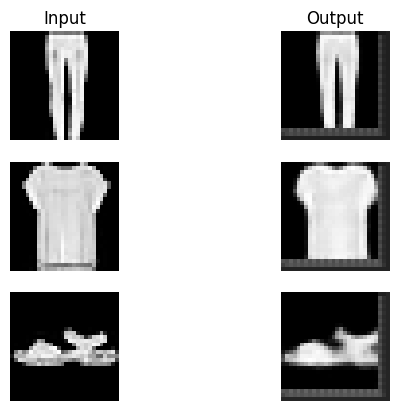

In [ ]:
figure=plt.figure()
rows,cols=3,2
i=0
model.eval()
for row in range(1,rows+1):
  j = [11,15,941,142]
  i+=1
  image,_=train_set[j[row]]
  figure.add_subplot(rows,cols,i)
  if row==1:
    plt.title('Input')
  plt.axis('off')
  plt.imshow(unbatch(image),cmap='Greys_r')

  i+=1
  figure.add_subplot(rows,cols,i)
  if row==1:
      plt.title('Output')
  plt.axis('off')
  image_pred=unbatch(model((batch(image))))
  plt.imshow(image_pred,cmap='Greys_r')

#Classifier

##Implementing the classifier

In [ ]:
# cargo el modelo autoencoder entrenado
# drive.mount('/content/drive')
# archivo_peso = '/content/drive/MyDrive/Redes Neuronales/TP FINAL/modelo_pesos.pth'
# model = Autoencoder_conv(n=128, p=0.2)
# model.load_state_dict(torch.load(archivo_peso))

In [ ]:
#implemento el clasificador
class Clasificador_conv(nn.Module):
    def __init__(self,n=64,p=0.1):
      super().__init__()
      self.n=Autoencoder_conv(n,p).n
      self.p=Autoencoder_conv(n,p).p
      #etapa encoder del autoencoder pasado
      self.encoder=copy.deepcopy(Autoencoder_conv(n,p).encoder)
      #capa lineal
      self.parte_lineal=nn.Sequential(
          nn.Linear(n,10),
          # nn.ReLU(),
          nn.Dropout(p)
      )
    def forward(self,x):
      x=self.encoder(x)
      x=self.parte_lineal(x)
      return x

In [ ]:
#reimplemento los valid y train loop: les agrego que calculen la precision

# Definimos la función de entrenamiento
def train_loop(dataloader,model,loss_fn,optimizer):
    # Activamos la maquinaria de entrenamiento del modelo (luego cuando evalue cambia ya que se tiene que desactivar el dropout)
    model.train()
    # Definimos ciertas constantes
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_loss,sum_correct = 0,0
    # Iteramos sobre lotes (batchs)
    for batch, (X, y) in enumerate(dataloader):
        # Copiamos las entradas y las salidas al dispositivo de trabajo
        X = X.to(device)
        y = y.to(device)
        # Calculamos la predicción del modelo y la correspondiente pérdida (error)
        pred = model(X)
        loss = loss_fn(pred,y)
        # Backpropagamos usando el optimizador proveido.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Imprimimos el progreso...
        loss_value = loss.item()
        sum_loss += loss_value
        # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
        sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        if batch % 100 == 0:
            current = batch*len(X)
            print(f"@train_loop batch={batch:>5d} loss={loss_value:>7f}  muestras-procesadas=[{current:>5d}/{size:>5d}]")
    avg_loss = sum_loss/num_batches
    precision = sum_correct/size
    return avg_loss,precision

# De manera similar, definimos la función de validación
def valid_loop(dataloader,model,loss_fn):
    # Desactivamos la maquinaria de entrenamiento del modelo
    model.eval()
    # Definimos ciertas constantes
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_loss,sum_correct = 0,0
    # Para testear, desactivamos el cálculo de gradientes.
    with torch.no_grad():
        # Iteramos sobre lotes (batches)
        for X,y in dataloader:
            # Copiamos las entradas y las salidas al dispositivo de trabajo
            X = X.to(device)
            y = y.to(device)
            # Calculamos las predicciones del modelo...
            pred = model(X)
            # y las correspondientes pérdidas (errores), los cuales vamos acumulando en un valor total.
            sum_loss += loss_fn(pred,y).item()
            # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
            sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculamos la pérdida total y la fracción de clasificaciones correctas, y las imprimimos.
    avg_loss = sum_loss/num_batches
    precision = sum_correct/size
    print(f"@valid_loop precision={(100*precision):>0.1f}% avg_loss={avg_loss:>8f}")
    return avg_loss,precision

##Variation of $p$, $n$, and $lr$

In [ ]:
num_epochs=30

###variaciones de n

Epoch 1 de 30-----n=64
-------------------------------
@train_loop batch=    0 loss=2.305010  muestras-procesadas=[    0/50000]
@train_loop batch=  100 loss=0.965215  muestras-procesadas=[10000/50000]
@train_loop batch=  200 loss=0.716348  muestras-procesadas=[20000/50000]
@train_loop batch=  300 loss=0.742607  muestras-procesadas=[30000/50000]
@train_loop batch=  400 loss=0.577061  muestras-procesadas=[40000/50000]
@valid_loop precision=79.8% avg_loss=0.555972
@valid_loop precision=79.0% avg_loss=0.574645
Epoch 2 de 30-----n=64
-------------------------------
@train_loop batch=    0 loss=0.635600  muestras-procesadas=[    0/50000]
@train_loop batch=  100 loss=0.579640  muestras-procesadas=[10000/50000]
@train_loop batch=  200 loss=0.648143  muestras-procesadas=[20000/50000]
@train_loop batch=  300 loss=0.484218  muestras-procesadas=[30000/50000]
@train_loop batch=  400 loss=0.408255  muestras-procesadas=[40000/50000]
@valid_loop precision=85.1% avg_loss=0.442318
@valid_loop precision=

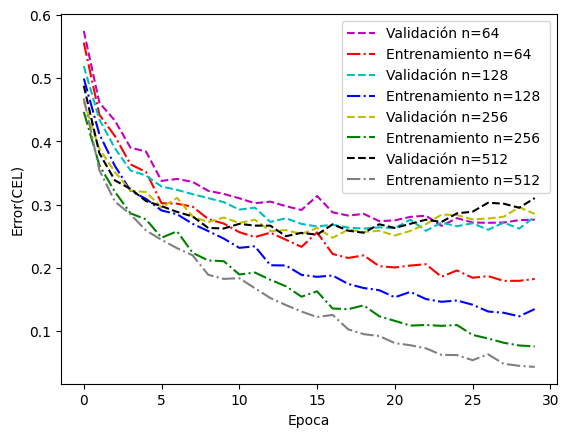

Text(0, 0.5, 'Precisión')

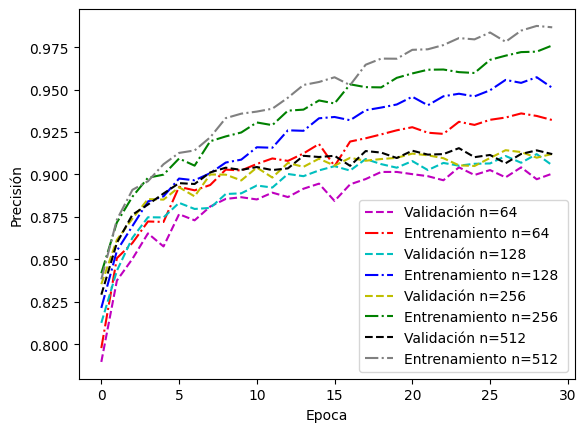

In [ ]:
# aplico variaciones de n
batch_size = 100
train_loader = torch.utils.data.DataLoader(train_set_orig, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_set_orig, batch_size = batch_size, shuffle = True)
lista_n=[64,128,256,512]
p=0.1
colores=['m','c','y','k']
colores_2=['r','b','g','grey']
listas_train=[]
listas_valid=[]
listas_prec_train=[]
listas_prec_valid=[]
loss_fn = nn.CrossEntropyLoss()
for i in range(len(lista_n)):
  n=lista_n[i]
  model=Clasificador_conv(n,p)
  learning_rate = 1e-3 # necesario para definir
  optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)
  list_train_avg_loss_incorrecta = []
  list_train_avg_loss = []
  list_valid_avg_loss = []
  list_valid_precision=[]
  list_train_precision=[]
  list_train_precision_incorrecta=[]
  for epoch in range(num_epochs):
        print(f"Epoch {epoch+1} de {num_epochs}-----n={n}\n-------------------------------")
        train_avg_loss_incorrecta,train_precision_incorrecta = train_loop(train_loader,model,loss_fn,optimizer)
        train_avg_loss,train_precision = valid_loop(train_loader,model,loss_fn)
        valid_avg_loss,valid_precision= valid_loop(valid_loader,model,loss_fn)
        list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)
        list_train_avg_loss.append(train_avg_loss)
        list_valid_avg_loss.append(valid_avg_loss)
        list_valid_precision.append(valid_precision)
        list_train_precision.append(train_precision)
        list_train_precision_incorrecta.append(train_precision_incorrecta)
  print("Done!")
  listas_train.append(list_train_avg_loss)
  listas_valid.append(list_valid_avg_loss)
  listas_prec_train.append(list_train_precision)
  listas_prec_valid.append(list_valid_precision)
for j in range(len(lista_n)):
  plt.plot(range(num_epochs),listas_valid[j],color=colores[j],label=f'Validación n={lista_n[j]} ',linestyle='--')
  plt.plot(range(num_epochs),listas_train[j],color=colores_2[j],label=f'Entrenamiento n={lista_n[j]} ',linestyle='-.')
plt.legend()
plt.xlabel('Epoca')
plt.ylabel('Error(CEL)')
plt.show()
for j in range(len(lista_n)):
  plt.plot(range(num_epochs),listas_prec_valid[j],color=colores[j],label=f'Validación n={lista_n[j]} ',linestyle='--')
  plt.plot(range(num_epochs),listas_prec_train[j],color=colores_2[j],label=f'Entrenamiento n={lista_n[j]} ',linestyle='-.')
plt.legend()
plt.xlabel('Epoca')
plt.ylabel('Precisión')

###variaciones de p

Epoch 1 de 30-----p=0.05
-------------------------------
@train_loop batch=    0 loss=2.300744  muestras-procesadas=[    0/50000]
@train_loop batch=  100 loss=0.861339  muestras-procesadas=[10000/50000]
@train_loop batch=  200 loss=0.784460  muestras-procesadas=[20000/50000]
@train_loop batch=  300 loss=0.534419  muestras-procesadas=[30000/50000]
@train_loop batch=  400 loss=0.522721  muestras-procesadas=[40000/50000]
@valid_loop precision=83.9% avg_loss=0.454058
@valid_loop precision=82.7% avg_loss=0.477822
Epoch 2 de 30-----p=0.05
-------------------------------
@train_loop batch=    0 loss=0.517152  muestras-procesadas=[    0/50000]
@train_loop batch=  100 loss=0.575989  muestras-procesadas=[10000/50000]
@train_loop batch=  200 loss=0.476842  muestras-procesadas=[20000/50000]
@train_loop batch=  300 loss=0.383947  muestras-procesadas=[30000/50000]
@train_loop batch=  400 loss=0.478073  muestras-procesadas=[40000/50000]
@valid_loop precision=86.3% avg_loss=0.380606
@valid_loop precis

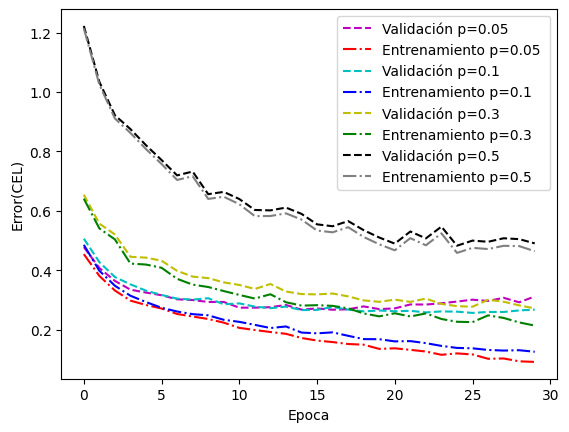

Text(0, 0.5, 'Precisión')

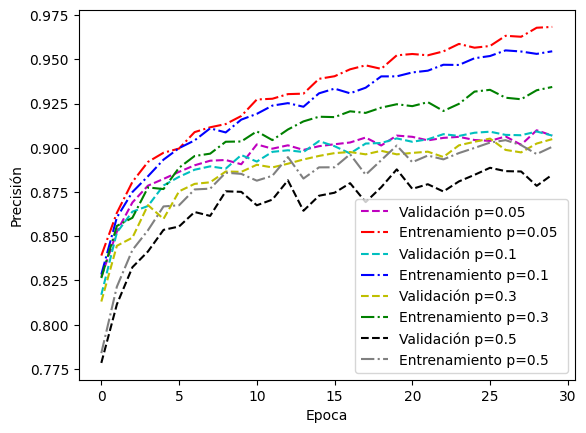

In [ ]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(train_set_orig, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_set_orig, batch_size = batch_size, shuffle = True)

lista_p=[0.05,0.1,0.3,0.5]
n=128
colores=['m','c','y','k']
colores_2=['r','b','g','grey']
listas_train=[]
listas_valid=[]
listas_prec_train=[]
listas_prec_valid=[]
loss_fn = nn.CrossEntropyLoss()
for i in range(len(lista_p)):
  p=lista_p[i]
  model=Clasificador_conv(n,p)
  learning_rate = 1e-3 # necesario para definir
  optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)
  list_train_avg_loss_incorrecta = []
  list_train_avg_loss = []
  list_valid_avg_loss = []
  list_valid_precision=[]
  list_train_precision=[]
  list_train_precision_incorrecta=[]
  for epoch in range(num_epochs):
        print(f"Epoch {epoch+1} de {num_epochs}-----p={p}\n-------------------------------")
        train_avg_loss_incorrecta,train_precision_incorrecta = train_loop(train_loader,model,loss_fn,optimizer)
        train_avg_loss,train_precision = valid_loop(train_loader,model,loss_fn)
        valid_avg_loss,valid_precision= valid_loop(valid_loader,model,loss_fn)
        list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)
        list_train_avg_loss.append(train_avg_loss)
        list_valid_avg_loss.append(valid_avg_loss)
        list_valid_precision.append(valid_precision)
        list_train_precision.append(train_precision)
        list_train_precision_incorrecta.append(train_precision_incorrecta)
  print("Done!")
  listas_train.append(list_train_avg_loss)
  listas_valid.append(list_valid_avg_loss)
  listas_prec_train.append(list_train_precision)
  listas_prec_valid.append(list_valid_precision)
for j in range(len(lista_p)):
  plt.plot(range(num_epochs),listas_valid[j],color=colores[j],label=f'Validación p={lista_p[j]} ',linestyle='--')
  plt.plot(range(num_epochs),listas_train[j],color=colores_2[j],label=f'Entrenamiento p={lista_p[j]} ',linestyle='-.')
plt.legend()
plt.xlabel('Epoca')
plt.ylabel('Error(CEL)')
plt.show()
for j in range(len(lista_p)):
  plt.plot(range(num_epochs),listas_prec_valid[j],color=colores[j],label=f'Validación p={lista_p[j]} ',linestyle='--')
  plt.plot(range(num_epochs),listas_prec_train[j],color=colores_2[j],label=f'Entrenamiento p={lista_p[j]} ',linestyle='-.')
plt.legend()
plt.xlabel('Epoca')
plt.ylabel('Precisión')

###Variacions del $lr$

Epoch 1 de 30-----lr=0.01
-------------------------------
@train_loop batch=    0 loss=2.312823  muestras-procesadas=[    0/50000]
@train_loop batch=  100 loss=0.826228  muestras-procesadas=[10000/50000]
@train_loop batch=  200 loss=0.508974  muestras-procesadas=[20000/50000]
@train_loop batch=  300 loss=0.495370  muestras-procesadas=[30000/50000]
@train_loop batch=  400 loss=0.614224  muestras-procesadas=[40000/50000]
@valid_loop precision=85.7% avg_loss=0.385894
@valid_loop precision=84.9% avg_loss=0.411144
Epoch 2 de 30-----lr=0.01
-------------------------------
@train_loop batch=    0 loss=0.708497  muestras-procesadas=[    0/50000]
@train_loop batch=  100 loss=0.711195  muestras-procesadas=[10000/50000]
@train_loop batch=  200 loss=0.610026  muestras-procesadas=[20000/50000]
@train_loop batch=  300 loss=0.523478  muestras-procesadas=[30000/50000]
@train_loop batch=  400 loss=0.569573  muestras-procesadas=[40000/50000]
@valid_loop precision=87.8% avg_loss=0.334982
@valid_loop prec

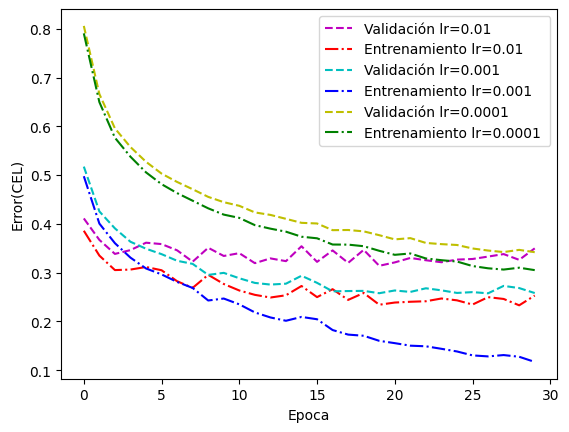

Text(0, 0.5, 'Precisión')

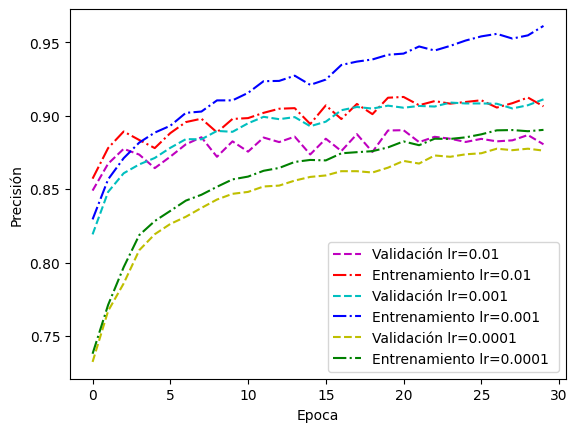

In [ ]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(train_set_orig, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_set_orig, batch_size = batch_size, shuffle = True)

lista_lr=[0.01,0.001,0.0001]
n=128
colores=['m','c','y','k']
colores_2=['r','b','g','grey']
listas_train=[]
listas_valid=[]
listas_prec_train=[]
listas_prec_valid=[]
loss_fn = nn.CrossEntropyLoss()
for i in range(len(lista_lr)):
  p=0.1
  model=Clasificador_conv(n,p)
  learning_rate = lista_lr[i]
  optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)
  list_train_avg_loss_incorrecta = []
  list_train_avg_loss = []
  list_valid_avg_loss = []
  list_valid_precision=[]
  list_train_precision=[]
  list_train_precision_incorrecta=[]
  for epoch in range(num_epochs):
        print(f"Epoch {epoch+1} de {num_epochs}-----lr={learning_rate}\n-------------------------------")
        train_avg_loss_incorrecta,train_precision_incorrecta = train_loop(train_loader,model,loss_fn,optimizer)
        train_avg_loss,train_precision = valid_loop(train_loader,model,loss_fn)
        valid_avg_loss,valid_precision= valid_loop(valid_loader,model,loss_fn)
        list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)
        list_train_avg_loss.append(train_avg_loss)
        list_valid_avg_loss.append(valid_avg_loss)
        list_valid_precision.append(valid_precision)
        list_train_precision.append(train_precision)
        list_train_precision_incorrecta.append(train_precision_incorrecta)
  print("Done!")
  listas_train.append(list_train_avg_loss)
  listas_valid.append(list_valid_avg_loss)
  listas_prec_train.append(list_train_precision)
  listas_prec_valid.append(list_valid_precision)
for j in range(len(lista_lr)):
  plt.plot(range(num_epochs),listas_valid[j],color=colores[j],label=f'Validación lr={lista_lr[j]} ',linestyle='--')
  plt.plot(range(num_epochs),listas_train[j],color=colores_2[j],label=f'Entrenamiento lr={lista_lr[j]} ',linestyle='-.')
plt.legend()
plt.xlabel('Epoca')
plt.ylabel('Error(CEL)')
plt.show()
for j in range(len(lista_lr)):
  plt.plot(range(num_epochs),listas_prec_valid[j],color=colores[j],label=f'Validación lr={lista_lr[j]} ',linestyle='--')
  plt.plot(range(num_epochs),listas_prec_train[j],color=colores_2[j],label=f'Entrenamiento lr={lista_lr[j]} ',linestyle='-.')
plt.legend()
plt.xlabel('Epoca')
plt.ylabel('Precisión')

##Traing the model with the best hyperparams

In [ ]:
num_epochs=30

Epoch 1
-------------------------------
@train_loop batch=    0 loss=2.316800  muestras-procesadas=[    0/50000]
@train_loop batch=  100 loss=0.893277  muestras-procesadas=[10000/50000]
@train_loop batch=  200 loss=0.652195  muestras-procesadas=[20000/50000]
@train_loop batch=  300 loss=0.627529  muestras-procesadas=[30000/50000]
@train_loop batch=  400 loss=0.619196  muestras-procesadas=[40000/50000]
@valid_loop precision=84.5% avg_loss=0.460389
@valid_loop precision=83.4% avg_loss=0.480382
Epoch 2
-------------------------------
@train_loop batch=    0 loss=0.586975  muestras-procesadas=[    0/50000]
@train_loop batch=  100 loss=0.544917  muestras-procesadas=[10000/50000]
@train_loop batch=  200 loss=0.461431  muestras-procesadas=[20000/50000]
@train_loop batch=  300 loss=0.623286  muestras-procesadas=[30000/50000]
@train_loop batch=  400 loss=0.549461  muestras-procesadas=[40000/50000]
@valid_loop precision=87.1% avg_loss=0.377179
@valid_loop precision=86.1% avg_loss=0.402877
Epoch 

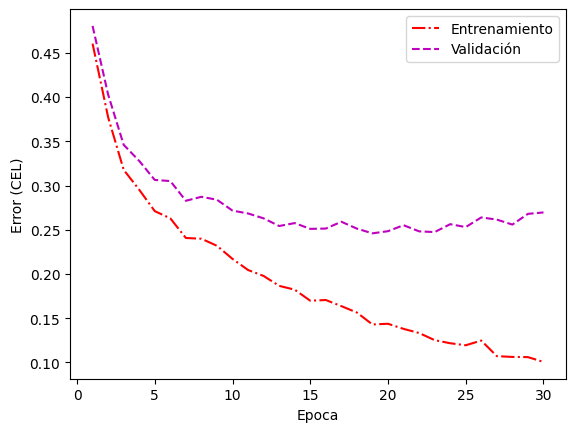

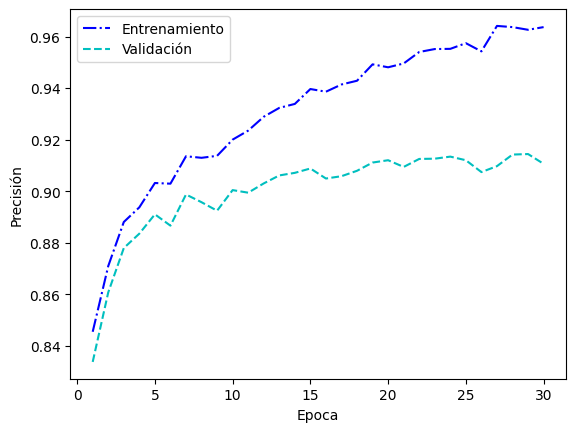

In [ ]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(train_set_orig, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_set_orig, batch_size = batch_size, shuffle = True)

learning_rate=0.001
n=128
p=0.1
model=Clasificador_conv(n,p)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)
list_train_avg_loss_incorrecta = []
list_train_avg_loss = []
list_valid_avg_loss = []
list_valid_precision=[]
list_train_precision=[]
list_train_precision_incorrecta=[]
for epoch in range(num_epochs):
      print(f"Epoch {epoch+1}\n-------------------------------")
      train_avg_loss_incorrecta,train_precision_incorrecta = train_loop(train_loader,model,loss_fn,optimizer)
      train_avg_loss,train_precision = valid_loop(train_loader,model,loss_fn)
      valid_avg_loss,valid_precision= valid_loop(valid_loader,model,loss_fn)
      list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)
      list_train_avg_loss.append(train_avg_loss)
      list_valid_avg_loss.append(valid_avg_loss)
      list_valid_precision.append(valid_precision)
      list_train_precision.append(train_precision)
      list_train_precision_incorrecta.append(train_precision_incorrecta)
print("Done!")

#grafico curva de error vs epoca
plt.xlabel('Epoca')
plt.ylabel('Error (CEL)')
# plt.plot(range(1,len(list_train_avg_loss_incorrecta)+1),list_train_avg_loss_incorrecta,label="train-incorr",linestyle='-',c='red')
plt.plot(range(1,len(list_train_avg_loss)+1),list_train_avg_loss,label="Entrenamiento",linestyle='-.',c='r')
plt.plot(range(1,len(list_valid_avg_loss)+1),list_valid_avg_loss,label="Validación",linestyle='--',c='m')

plt.legend()
plt.show()
plt.xlabel('Epoca')
plt.ylabel('Precisión')
plt.plot(range(1,len(list_train_precision)+1),list_train_precision,label="Entrenamiento",linestyle='-.',c='b')
plt.plot(range(1,len(list_valid_precision)+1),list_valid_precision,label="Validación",linestyle='--',c='c')
plt.legend()
plt.show()

###Confussion matrix

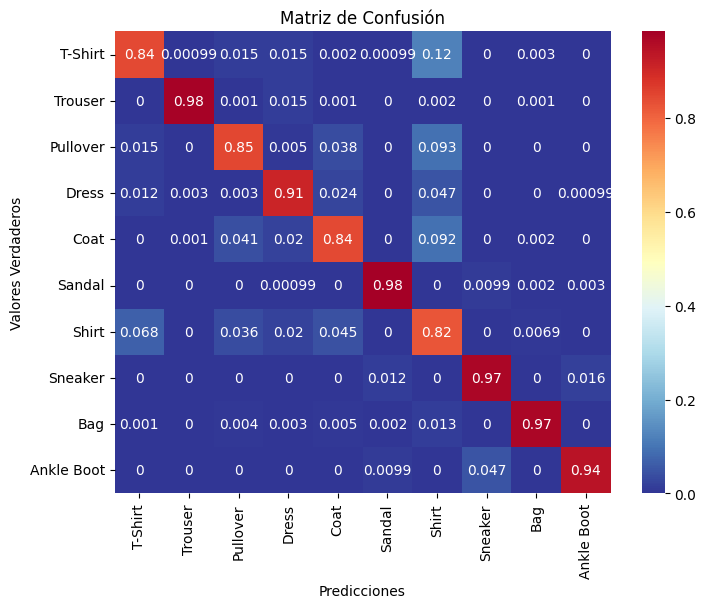

In [ ]:
# ploteo la matriz de confusion
salida_correcta=[]
salida_predic=[]
for i in range(len(test_set_orig)):
  input,output=test_set_orig[i]
  salida_correcta.append(output)
  pred=model(batch(input))
  salida_predic.append(pred.argmax(1).item())

import seaborn as sns
cm = confusion_matrix(salida_correcta, salida_predic)
cm_normalizada = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# Configurar las etiquetas de los ejes
clases = [labels_names[n] for n in range(10)]
# Visualizar la matriz de confusión con etiquetas personalizadas
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalizada, annot=True, cmap="RdYlBu_r", xticklabels=clases, yticklabels=clases)
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

#Extra study: dropping the pooling layer

##implemento el nuevo modelo sin pooling

In [ ]:
##
class AutoencoderConv(nn.Module):
    def __init__(self, n, p=0.05):
        super(AutoencoderConv, self).__init__()

        # Encoder con Dropout
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout2d(p),
            nn.Flatten()
        )

        # Capa lineal en el encoder aca le paso directamente las dim del flaten
        self.linear_layer = nn.Linear(32 * 7 * 7, n)

        # Decoder con Dropout
        self.decoder = nn.Sequential(
            nn.Linear(n, 32 * 7 * 7),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Dropout2d(p),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.linear_layer(x)
        x = self.decoder(x)
        return x

# Funciones de entrenamiento y validación
def train_loop(model, train_loader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = loss_fn(outputs, data)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch_idx % 100 == 99:
            print(f'Train Batch: [{batch_idx+1}/{len(train_loader)}]\t Loss: {running_loss/100:.6f}')
            running_loss = 0.0

def val_loop(model, val_loader, loss_fn, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for data, _ in val_loader:
            data = data.to(device)
            outputs = model(data)
            loss = loss_fn(outputs, data)
            running_loss += loss.item()

    avg_loss = running_loss / len(val_loader)
    print(f'Validation set: Average Loss: {avg_loss:.6f}')
    return avg_loss

##con los mismos parametros que con pooling, implemento el autoencoder

Epoch 1/30, n=128, p=0.1
Train Batch: [100/500]	 Loss: 0.075092
Train Batch: [200/500]	 Loss: 0.033633
Train Batch: [300/500]	 Loss: 0.025806
Train Batch: [400/500]	 Loss: 0.022440
Train Batch: [500/500]	 Loss: 0.020041
Validation set: Average Loss: 0.014336
Validation set: Average Loss: 0.014450
Epoch 2/30, n=128, p=0.1
Train Batch: [100/500]	 Loss: 0.018380
Train Batch: [200/500]	 Loss: 0.017089
Train Batch: [300/500]	 Loss: 0.016066
Train Batch: [400/500]	 Loss: 0.015297
Train Batch: [500/500]	 Loss: 0.014530
Validation set: Average Loss: 0.010731
Validation set: Average Loss: 0.010865
Epoch 3/30, n=128, p=0.1
Train Batch: [100/500]	 Loss: 0.014145
Train Batch: [200/500]	 Loss: 0.013411
Train Batch: [300/500]	 Loss: 0.013050
Train Batch: [400/500]	 Loss: 0.012538
Train Batch: [500/500]	 Loss: 0.012207
Validation set: Average Loss: 0.008873
Validation set: Average Loss: 0.009020
Epoch 4/30, n=128, p=0.1
Train Batch: [100/500]	 Loss: 0.011832
Train Batch: [200/500]	 Loss: 0.011525
Tra

Text(0, 0.5, 'Error (ECM)')

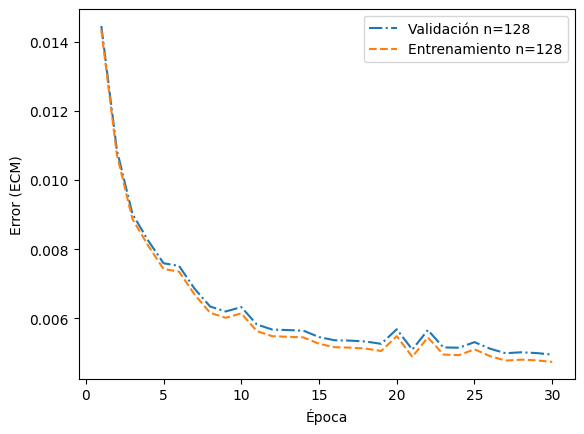

In [ ]:
n=128
p=0.1
train_loader = DataLoader(train_set, batch_size=100, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=100, shuffle=False)
    # Crear una instancia del modelo con diferentes valores de n y p
model = AutoencoderConv(n=n, p=p)
model.to(device)

    # Definir función de pérdida y optimizador
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Entrenamiento y validación
num_epochs = 30
val_losses = []
train_losses=[]
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}, n={n}, p={p}')
    train_loss_incorrect=train_loop(model, train_loader, loss_fn, optimizer, device)
    train_loss=val_loop(model, train_loader, loss_fn, device)
    val_loss = val_loop(model, val_loader, loss_fn, device)
    val_losses.append(val_loss)

    train_losses.append(train_loss)
    # Plotear las curvas de pérdida de validación
plt.plot(range(1, num_epochs + 1), val_losses, label=f'Validación n={n}',linestyle='-.')
plt.plot(range(1, num_epochs + 1), train_losses, label=f'Entrenamiento n={n}',linestyle='--')

plt.legend()

plt.xlabel('Época')
plt.ylabel('Error (ECM)')

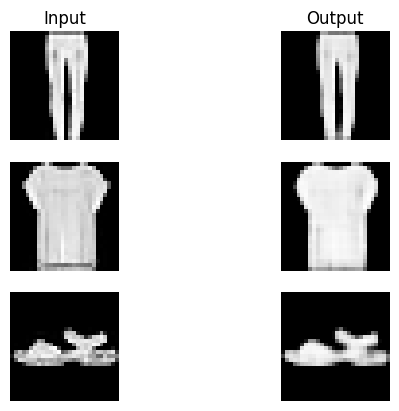

In [ ]:
figure=plt.figure()
rows,cols=3,2
i=0
model.eval()
for row in range(1,rows+1):
  j = [11,15,941,142]
  i+=1
  image,_=train_set[j[row]]
  figure.add_subplot(rows,cols,i)
  if row==1:
    plt.title('Input')
  plt.axis('off')
  plt.imshow(unbatch(image),cmap='Greys_r')

  i+=1
  figure.add_subplot(rows,cols,i)
  if row==1:
      plt.title('Output')
  plt.axis('off')
  image_pred=unbatch(model((batch(image))))
  plt.imshow(image_pred,cmap='Greys_r')

##y ahora el clasificador

In [ ]:
num_epochs=30

In [ ]:
import copy
# Clase para el clasificador utilizando el encoder del autoencoder
class Clasificador_conv(nn.Module):
    def __init__(self, encoder, n=64, p=0.1):
        super().__init__()
        self.n = n
        self.p = p
        # Etapa encoder del autoencoder pasado
        self.encoder = encoder
        # Capa lineal
        self.parte_lineal = nn.Sequential(
            nn.Linear(1568, 10),
            nn.Dropout(p)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.parte_lineal(x)
        return x
# Definimos la función de entrenamiento
def train_loop(dataloader,model,loss_fn,optimizer):
    # Activamos la maquinaria de entrenamiento del modelo (luego cuando evalue cambia ya que se tiene que desactivar el dropout)
    model.train()
    # Definimos ciertas constantes
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_loss,sum_correct = 0,0
    # Iteramos sobre lotes (batchs)
    for batch, (X, y) in enumerate(dataloader):
        # Copiamos las entradas y las salidas al dispositivo de trabajo
        X = X.to(device)
        y = y.to(device)
        # Calculamos la predicción del modelo y la correspondiente pérdida (error)
        pred = model(X)
        loss = loss_fn(pred,y)
        # Backpropagamos usando el optimizador proveido.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Imprimimos el progreso...
        loss_value = loss.item()
        sum_loss += loss_value
        # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
        sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        if batch % 100 == 0:
            current = batch*len(X)
            print(f"@train_loop batch={batch:>5d} loss={loss_value:>7f}  muestras-procesadas=[{current:>5d}/{size:>5d}]")
    avg_loss = sum_loss/num_batches
    precision = sum_correct/size
    return avg_loss,precision

# 5.2)
# De manera similar, definimos la función de validación
def valid_loop(dataloader,model,loss_fn):
    # Desactivamos la maquinaria de entrenamiento del modelo
    model.eval()
    # Definimos ciertas constantes
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_loss,sum_correct = 0,0
    # Para testear, desactivamos el cálculo de gradientes.
    with torch.no_grad():
        # Iteramos sobre lotes (batches)
        for X,y in dataloader:
            # Copiamos las entradas y las salidas al dispositivo de trabajo
            X = X.to(device)
            y = y.to(device)
            # Calculamos las predicciones del modelo...
            pred = model(X)
            # y las correspondientes pérdidas (errores), los cuales vamos acumulando en un valor total.
            sum_loss += loss_fn(pred,y).item()
            # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
            sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculamos la pérdida total y la fracción de clasificaciones correctas, y las imprimimos.
    avg_loss = sum_loss/num_batches
    precision = sum_correct/size
    print(f"@valid_loop precision={(100*precision):>0.1f}% avg_loss={avg_loss:>8f}")
    return avg_loss,precision

train_loader = DataLoader(train_set_orig, batch_size=100, shuffle=True)
valid_loader = DataLoader(valid_set_orig, batch_size=100, shuffle=False)

n=128

# Crear una instancia del clasificador con ReLU y Dropout

model = Clasificador_conv(model.encoder, p=0.05)
model.to(device)

# ... (Cargar datos de Fashion MNIST y definir DataLoader)

# Definir función de pérdida y optimizador para el clasificador
loss_fn = nn.CrossEntropyLoss()  # Entropía cruzada para clasificación
optimizer = optim.Adam(model.parte_lineal.parameters(), lr=0.001)

# Entrenar el clasificador usando el encoder del autoencoder


list_train_avg_loss_incorrecta = []
list_train_avg_loss = []
list_valid_avg_loss = []
list_valid_precision=[]
list_train_precision=[]
list_train_precision_incorrecta=[]
for epoch in range(num_epochs):
      print(f"Epoch {epoch+1}\n-------------------------------")
      train_avg_loss_incorrecta,train_precision_incorrecta = train_loop(train_loader,model,loss_fn,optimizer)
      train_avg_loss,train_precision = valid_loop(train_loader,model,loss_fn)
      valid_avg_loss,valid_precision= valid_loop(valid_loader,model,loss_fn)
      list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)
      list_train_avg_loss.append(train_avg_loss)
      list_valid_avg_loss.append(valid_avg_loss)
      list_valid_precision.append(valid_precision)
      list_train_precision.append(train_precision)
      list_train_precision_incorrecta.append(train_precision_incorrecta)
print("Done!")


Epoch 1
-------------------------------
@train_loop batch=    0 loss=2.317565  muestras-procesadas=[    0/50000]
@train_loop batch=  100 loss=0.967495  muestras-procesadas=[10000/50000]
@train_loop batch=  200 loss=0.853334  muestras-procesadas=[20000/50000]
@train_loop batch=  300 loss=0.749454  muestras-procesadas=[30000/50000]
@train_loop batch=  400 loss=0.769698  muestras-procesadas=[40000/50000]
@valid_loop precision=81.9% avg_loss=0.565999
@valid_loop precision=81.1% avg_loss=0.588228
Epoch 2
-------------------------------
@train_loop batch=    0 loss=0.684043  muestras-procesadas=[    0/50000]
@train_loop batch=  100 loss=0.543565  muestras-procesadas=[10000/50000]
@train_loop batch=  200 loss=0.657567  muestras-procesadas=[20000/50000]
@train_loop batch=  300 loss=0.552614  muestras-procesadas=[30000/50000]
@train_loop batch=  400 loss=0.541434  muestras-procesadas=[40000/50000]
@valid_loop precision=84.3% avg_loss=0.477436
@valid_loop precision=83.3% avg_loss=0.504429
Epoch 

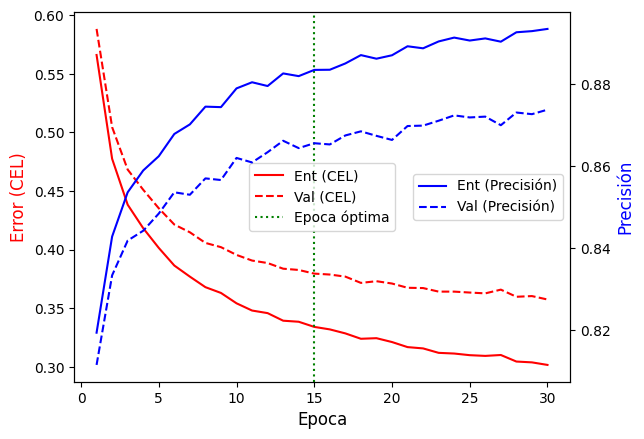

In [ ]:
# Datos de ejemplo (reemplázalos con tus propios datos)
epocas = range(1, len(list_train_avg_loss) + 1)


# Crear una figura y ejes
fig, ax1 = plt.subplots()

# Duplicar los ejes y compartir el eje x
ax2 = ax1.twinx()

# Configurar colores de los ejes
ax1.set_xlabel('Epoca',fontsize=12)
ax1.set_ylabel('Error (CEL)', color='red',fontsize=12)
ax2.set_ylabel('Precisión', color='blue',fontsize=12)

# Plotear datos en los ejes correspondientes
ax1.plot(epocas, list_train_avg_loss, 'r', label='Ent (CEL)')
ax1.plot(epocas, list_valid_avg_loss, 'r--', label='Val (CEL)')

ax2.plot(epocas, list_train_precision, 'b', label='Ent (Precisión)')
ax2.plot(epocas, list_valid_precision, 'b--', label='Val (Precisión)')

# Añadir línea vertical y leyendas
ax1.axvline(15, linestyle='dotted', c='g', label='Epoca óptima')
ax1.legend(loc='center')
ax2.legend(loc='center right')

# Mostrar el gráfico
plt.show()

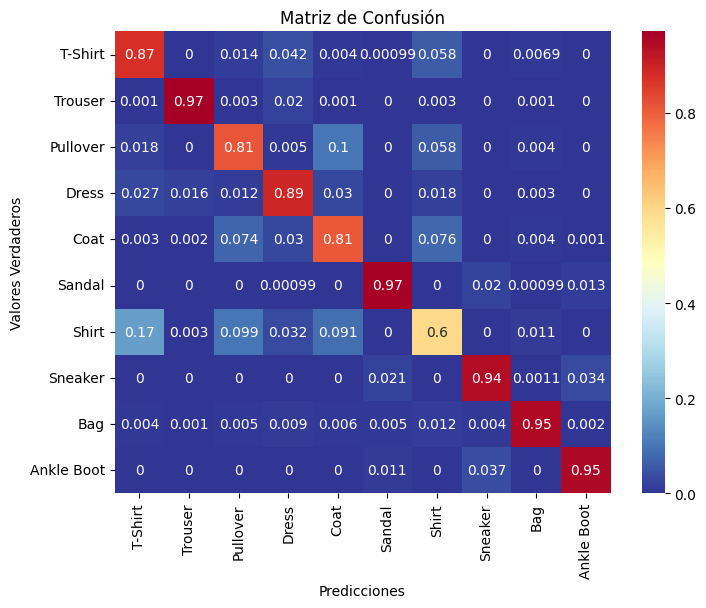

In [ ]:

salida_correcta=[]
salida_predic=[]
for i in range(len(test_set_orig)):
  input,output=test_set_orig[i]
  salida_correcta.append(output)
  pred=model(batch(input))
  salida_predic.append(pred.argmax(1).item())

import seaborn as sns
cm = confusion_matrix(salida_correcta, salida_predic)
cm_normalizada = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# Configurar las etiquetas de los ejes
clases = [labels_names[n] for n in range(10)]
# Visualizar la matriz de confusión con etiquetas personalizadas
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalizada, annot=True, cmap="RdYlBu_r", xticklabels=clases, yticklabels=clases)
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

#Extra study: modifiyng partially the weights using the ADAM optimizer
Comparising the performance when using the partial actualization of the weights instead of a total actualization (autoencoder's weigths and classifier weights)

In [ ]:
num_epochs=1

In [ ]:
class Clasificador_conv(nn.Module):
    def __init__(self,n=64,p=0.1):
      super().__init__()
      self.n=Autoencoder_conv(n,p).n
      self.p=Autoencoder_conv(n,p).p
      #etapa encoder del autoencoder pasado
      self.encoder=copy.deepcopy(Autoencoder_conv(n,p).encoder)
      #capa lineal
      self.parte_lineal=nn.Sequential(
          nn.Linear(n,10),
          # nn.ReLU(),
          nn.Dropout(p)
      )
    def forward(self,x):
      x=self.encoder(x)
      x=self.parte_lineal(x)
      return x
# Definimos la función de entrenamiento
def train_loop(dataloader,model,loss_fn,optimizer):
    # Activamos la maquinaria de entrenamiento del modelo (luego cuando evalue cambia ya que se tiene que desactivar el dropout)
    model.train()
    # Definimos ciertas constantes
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_loss,sum_correct = 0,0
    # Iteramos sobre lotes (batchs)
    for batch, (X, y) in enumerate(dataloader):
        # Copiamos las entradas y las salidas al dispositivo de trabajo
        X = X.to(device)
        y = y.to(device)
        # Calculamos la predicción del modelo y la correspondiente pérdida (error)
        pred = model(X)
        loss = loss_fn(pred,y)
        # Backpropagamos usando el optimizador proveido.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Imprimimos el progreso...
        loss_value = loss.item()
        sum_loss += loss_value
        # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
        sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        if batch % 100 == 0:
            current = batch*len(X)
            print(f"@train_loop batch={batch:>5d} loss={loss_value:>7f}  muestras-procesadas=[{current:>5d}/{size:>5d}]")
    avg_loss = sum_loss/num_batches
    precision = sum_correct/size
    return avg_loss,precision

# De manera similar, definimos la función de validación
def valid_loop(dataloader,model,loss_fn):
    # Desactivamos la maquinaria de entrenamiento del modelo
    model.eval()
    # Definimos ciertas constantes
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_loss,sum_correct = 0,0
    # Para testear, desactivamos el cálculo de gradientes.
    with torch.no_grad():
        # Iteramos sobre lotes (batches)
        for X,y in dataloader:
            # Copiamos las entradas y las salidas al dispositivo de trabajo
            X = X.to(device)
            y = y.to(device)
            # Calculamos las predicciones del modelo...
            pred = model(X)
            # y las correspondientes pérdidas (errores), los cuales vamos acumulando en un valor total.
            sum_loss += loss_fn(pred,y).item()
            # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
            sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculamos la pérdida total y la fracción de clasificaciones correctas, y las imprimimos.
    avg_loss = sum_loss/num_batches
    precision = sum_correct/size
    print(f"@valid_loop precision={(100*precision):>0.1f}% avg_loss={avg_loss:>8f}")
    return avg_loss,precision

In [ ]:
#implemento los dataloaders
batch_size = 100
train_loader = torch.utils.data.DataLoader(train_set_orig, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_set_orig, batch_size = batch_size, shuffle = True)

model=Clasificador_conv(n,p)
loss_fn = nn.CrossEntropyLoss()

learning_rate = 1e-3
'''
en la linea que sigue desactivar el parte lineal si se quiere que no se fijen los pesos
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)
'''
optimizer = torch.optim.Adam(model.parte_lineal.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)
n,p=128,0.1

list_train_avg_loss_incorrecta = []
list_train_avg_loss = []
list_valid_avg_loss = []
list_valid_precision=[]
list_train_precision=[]
list_train_precision_incorrecta=[]
for epoch in range(num_epochs):
      print(f"Epoch {epoch+1}\n-------------------------------")
      train_avg_loss_incorrecta,train_precision_incorrecta = train_loop(train_loader,model,loss_fn,optimizer)
      train_avg_loss,train_precision = valid_loop(train_loader,model,loss_fn)
      valid_avg_loss,valid_precision= valid_loop(valid_loader,model,loss_fn)
      list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)
      list_train_avg_loss.append(train_avg_loss)
      list_valid_avg_loss.append(valid_avg_loss)
      list_valid_precision.append(valid_precision)
      list_train_precision.append(train_precision)
      list_train_precision_incorrecta.append(train_precision_incorrecta)
print("Done!")

Epoch 1
-------------------------------
@train_loop batch=    0 loss=2.305271  muestras-procesadas=[    0/50000]
@train_loop batch=  100 loss=2.243687  muestras-procesadas=[10000/50000]
@train_loop batch=  200 loss=2.195364  muestras-procesadas=[20000/50000]
@train_loop batch=  300 loss=2.152892  muestras-procesadas=[30000/50000]
@train_loop batch=  400 loss=2.087939  muestras-procesadas=[40000/50000]
@valid_loop precision=66.5% avg_loss=2.098412
@valid_loop precision=65.8% avg_loss=2.100435
Done!


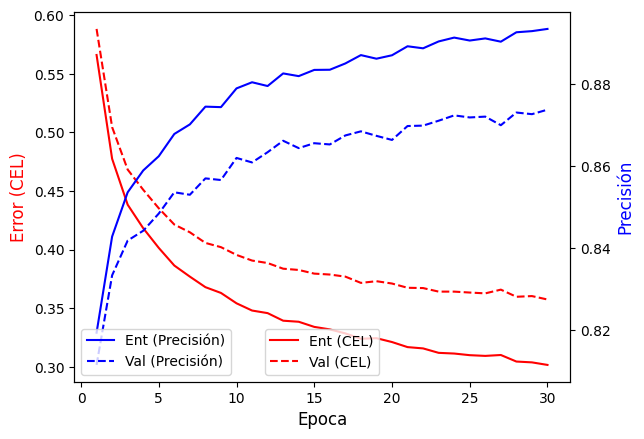

In [ ]:
# Datos de ejemplo (reemplázalos con tus propios datos)
epocas = range(1, len(list_train_avg_loss) + 1)


# Crear una figura y ejes
fig, ax1 = plt.subplots()

# Duplicar los ejes y compartir el eje x
ax2 = ax1.twinx()

# Configurar colores de los ejes
ax1.set_xlabel('Epoca',fontsize=12)
ax1.set_ylabel('Error (CEL)', color='red',fontsize=12)
ax2.set_ylabel('Precisión', color='blue',fontsize=12)

# Plotear datos en los ejes correspondientes
ax1.plot(epocas, list_train_avg_loss, 'r', label='Ent (CEL)')
ax1.plot(epocas, list_valid_avg_loss, 'r--', label='Val (CEL)')

ax2.plot(epocas, list_train_precision, 'b', label='Ent (Precisión)')
ax2.plot(epocas, list_valid_precision, 'b--', label='Val (Precisión)')

# Añadir línea vertical y leyendas
# ax1.axvline(15, linestyle='dotted', c='g', label='Epoca óptima')
ax1.legend(loc='lower center')
ax2.legend(loc='lower left')

# Mostrar el gráfico
plt.show()